In [1]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [2]:
import datetime
import os
import matplotlib
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from notebook_shared import utils
from notebook_shared import violinplotutil

from statsmodels.tsa.seasonal import seasonal_decompose
from pandas import Series

import seaborn as sns
sns.set()
matplotlib.style.use('seaborn-colorblind')

INPUT_FILE = "dataset"
FSIZE = "full"

df = pd.read_parquet(utils.get_dataset_path(INPUT_FILE, FSIZE))
sns.set(font_scale=1.2)

In [3]:
def custom_boxplot(ax, df, ytitle, tickf, rot=0, sharex=False, showfliers=False):
    fig = ax.get_figure()
    gs = ax.get_subplotspec()
    ax = plt.gca()
    df.boxplot(subplots=False, ax=ax, showfliers=showfliers, sharex=sharex)

    if (sharex):
        ax.set_xticklabels([])
    else:
        labels = []
        for tick in ax.get_xticklabels():
            labels.append(tickf(tick))
        ax.set_xticklabels(labels)
        plt.setp(ax.get_xticklabels(), rotation=rot)

    ax.set_ylabel(ytitle)

    return ax

In [4]:
df[['driver_invocation', 'workload_invocation', 'provider', 'region', '1_run_id']]

,driver_invocation,workload_invocation,provider,region,1_run_id
0,2021-08-01 13:30:03.035,2021-08-01 13:30:42.746,AWS,ap-northeast-1,0
1,2021-08-01 13:30:03.035,2021-08-01 13:30:42.746,AWS,ap-northeast-1,0
2,2021-08-01 13:30:03.035,2021-08-01 13:30:42.746,AWS,ap-northeast-1,0
3,2021-08-01 13:30:03.035,2021-08-01 13:30:42.746,AWS,ap-northeast-1,0
4,2021-08-01 13:30:03.035,2021-08-01 13:30:42.746,AWS,ap-northeast-1,1
...,...,...,...,...,...
49935595,2021-09-30 23:30:03.438,2021-09-30 23:30:22.629,GCP,us-west4,148
49935596,2021-09-30 23:30:03.438,2021-09-30 23:30:22.629,GCP,us-west4,149
49935597,2021-09-30 23:30:03.438,2021-09-30 23:30:22.629,GCP,us-west4,149
49935598,2021-09-30 23:30:03.438,2021-09-30 23:30:22.629,GCP,us-west4,149


In [5]:
# Common Stuff
provider_region_mapping = {}
provider_region_mg_df = df.groupby( ['provider', 'region'], observed=True)['measure group'].unique().reset_index()
provider_region_mg_df
for index, row in provider_region_mg_df.iterrows():
    for measure_group in row['measure group']:
        region = row['region']
        provider = row['provider']
        measure_group = row['measure group'][0]
        provider_region_mapping[f"({provider}, {region})"] = {'region': region, 'measure group': measure_group, 'provider': provider}
        provider_region_mapping[f"({provider}, {region}, {measure_group})"] = {'region': region, 'measure group': measure_group, 'provider': provider}

# Mean Runtime and CV Per Provider
- Q: Has a provider a overall characterstics or do specific regions stand out?
- Q: Does have one provider an overall more volatile region?

In [6]:
cov_df = df.groupby( ['provider', 'region'], observed=True)['runtime'].apply(utils.cov)

AWS


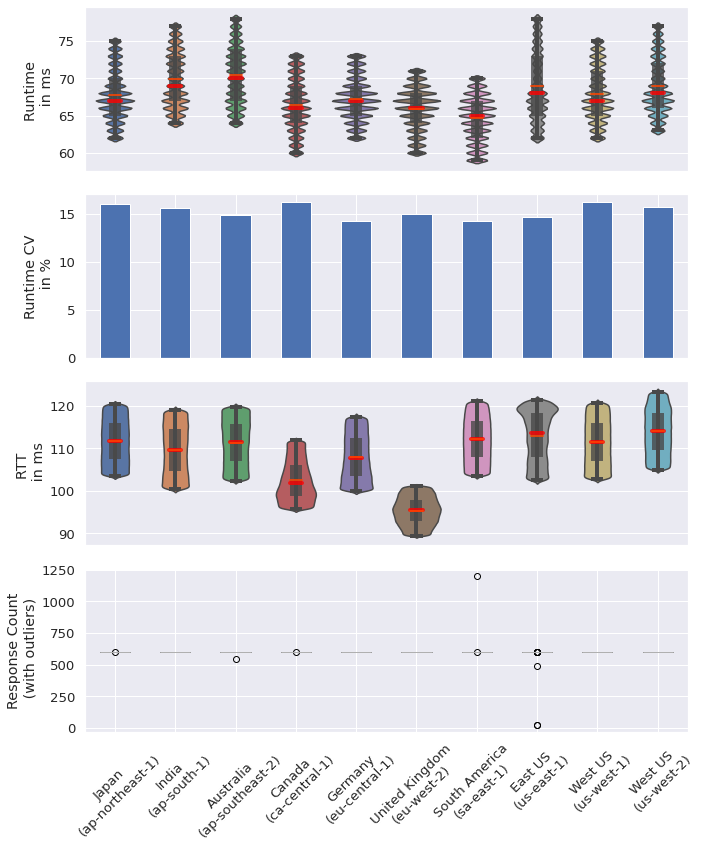

runtimebx 
                           runtime                                         \
                            count       mean       std   min   25%   50%   
provider region                                                            
AWS      ap-northeast-1  926387.0  67.779340  3.507182  62.0  65.0  67.0   
         ap-south-1      871720.0  69.873786  3.818698  64.0  67.0  69.0   
         ap-southeast-2  945986.0  70.484830  4.022142  64.0  67.0  70.0   
         ca-central-1    923543.0  66.469524  3.631024  60.0  64.0  66.0   
         eu-central-1    904657.0  67.237836  2.954712  62.0  65.0  67.0   
         eu-west-2       926541.0  65.859413  2.972326  60.0  64.0  66.0   
         sa-east-1       914609.0  64.603310  3.100743  59.0  62.0  65.0   
         us-east-1       933410.0  68.948700  4.664786  62.0  65.0  68.0   
         us-west-1       901966.0  67.936187  3.653996  62.0  65.0  67.0   
         us-west-2       943479.0  69.012228  3.867792  63.0  66.0  68.0   


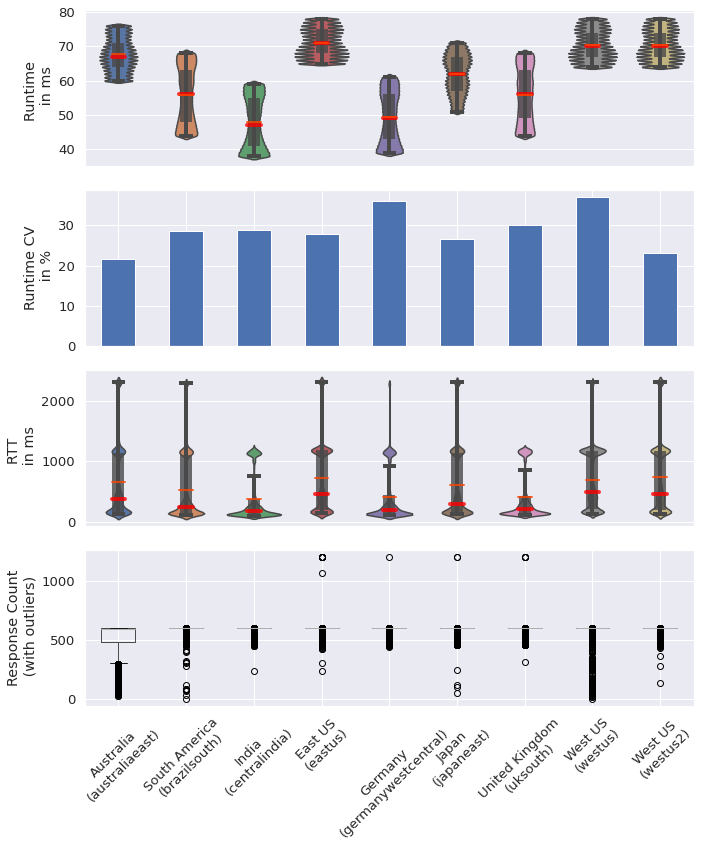

runtimebx 
                               runtime                                         \
                                count       mean       std   min   25%   50%   
provider region                                                                
AZURE    australiaeast       791029.0  67.717206  4.673027  60.0  64.0  67.0   
         brazilsouth         890645.0  55.839857  7.842681  44.0  48.0  56.0   
         centralindia        879161.0  47.853478  7.073692  38.0  41.0  47.0   
         eastus              924545.0  71.017867  4.001760  65.0  68.0  71.0   
         germanywestcentral  900423.0  49.398828  7.127824  39.0  43.0  49.0   
         japaneast           890760.0  61.960560  5.607318  51.0  57.0  62.0   
         uksouth             895755.0  55.959593  7.537987  44.0  49.0  56.0   
         westus              914007.0  70.459758  4.238704  64.0  67.0  70.0   
         westus2             914071.0  70.531010  4.231152  64.0  67.0  70.0   

                           

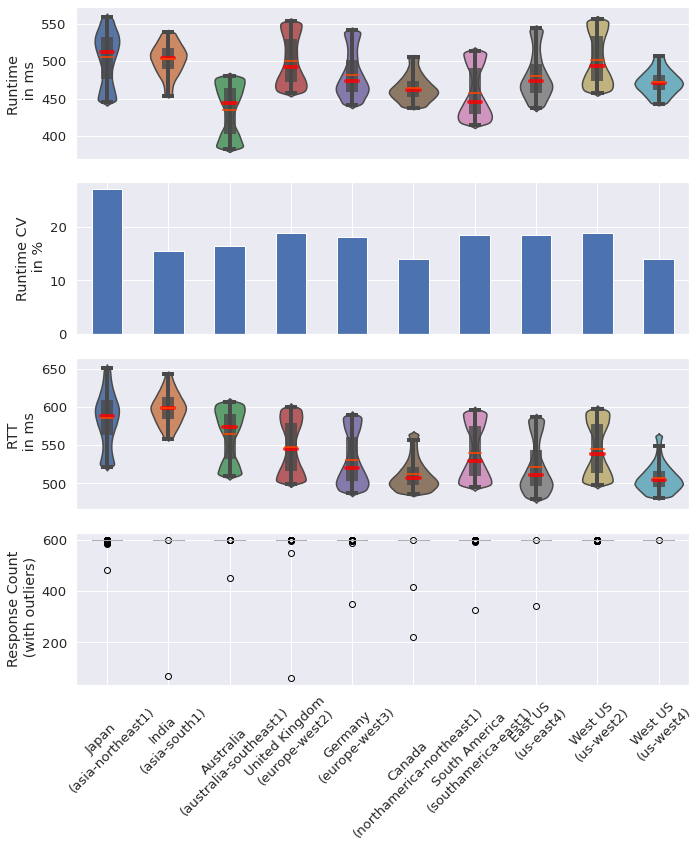

runtimebx 
                                    runtime                                \
                                     count        mean        std    min   
provider region                                                            
GCP      asia-northeast1          883224.0  505.174002  32.888018  445.0   
         asia-south1              872872.0  502.361271  19.932936  454.0   
         australia-southeast1     881507.0  435.199654  32.192091  383.0   
         europe-west2             872649.0  499.592205  30.354491  457.0   
         europe-west3             877572.0  481.894707  28.461980  441.0   
         northamerica-northeast1  872616.0  464.305939  16.154973  438.0   
         southamerica-east1       888317.0  457.155115  32.298694  415.0   
         us-east4                 875937.0  479.939366  28.431815  437.0   
         us-west2                 887440.0  501.672008  31.369217  458.0   
         us-west4                 872538.0  471.936208  15.038465  443.0   


In [7]:
sns.set(font_scale=1.2)

for provider in df['provider'].unique():
    SHAREX = True
    fig, axes = plt.subplots(figsize=(10,12), nrows=4, frameon=False, sharex=SHAREX)
    
    # Runtime
    pdf = df[['provider', 'region', 'runtime']][df['provider'] == provider]
    pdf = utils.remove_outliers_group_quantiles(pdf, 'region', 'runtime')
    
    
    pdf['runtime'] = pdf['runtime'].astype(np.float64)
    pdf['region'] = pdf['region'].cat.remove_unused_categories()
        
    violinplotutil.violinplot(x='region', y='runtime', ax=axes[0], data=pdf)
    
    axes[0].set_ylabel('Runtime \n in ms')
    
    bxdf = pdf.groupby(['provider','region'], observed=True)
    
    # COV
    cov_provider = cov_df.loc[provider] 
    cov_provider = cov_provider * 100
    cov_provider.plot(kind='bar', ax=axes[1], sharex=SHAREX)
    axes[1].set_ylabel('Runtime CV\n in %')
    
    # Round Trip Time
    if (provider == "AWS"):
        pdf = df[['provider', 'region', 'roundTripTime']][df['provider'] == provider]
        
        # pdf = utils.remove_outliers_group(pdf, 'region', 'roundTripTime')
        pdf = utils.remove_outliers_group_quantiles(pdf, 'region', 'roundTripTime')
        
        # todo check if ok
        pdf['roundTripTime'] = pdf['roundTripTime'].astype(np.float64)
        pdf['region'] = pdf['region'].cat.remove_unused_categories()
        
        violinplotutil.violinplot(x='region', y='roundTripTime', ax=axes[2], data=pdf)
        
        rtt_df = pdf.groupby(['region'], observed=True)
        # utils.boxplot(axes[2], rtt_df, 'Round Trip Time', lambda x: x, rot=90, sharex=SHAREX, showfliers=True)
    else:
        pdf = df[['provider', 'region', 'roundTripTime']][df['provider'] == provider]
        pdf = utils.remove_outliers_group_quantiles(pdf, 'region', 'roundTripTime')
        
        # todo check if ok
        pdf['roundTripTime'] = pdf['roundTripTime'].astype(np.float64)
        pdf['region'] = pdf['region'].cat.remove_unused_categories()
        
        violinplotutil.violinplot(x='region', y='roundTripTime', ax=axes[2], data=pdf)
        
        rtt_df = pdf.groupby(['region'], observed=True)
    
    axes[2].set_ylabel('RTT \n in ms')
    
    # resp df
    resp_df = df[df['provider'] == provider].groupby( ['provider', 'region', 'driver_invocation'], observed=True).size().reset_index(name='counts')
    df_resp_boxplot = resp_df[['provider', 'region', 'counts']].groupby(['provider', 'region'], observed=True)
    ax = utils.boxplot(axes[3], df_resp_boxplot, 'Response Count\n (with outliers)', lambda x: x, rot=45, sharex=False, showfliers=True)
    
    # Set Region Names
    region_name_ax = ax
    labels = []
    for tick in region_name_ax.get_xticklabels():
        region = tick.get_text().split(',')[1].strip()
        key = f"({provider}, {region})"
        mapping = provider_region_mapping[key]
        region = mapping['region']
        measure_group = mapping['measure group']
        labels.append(f"{measure_group}\n({region})")

    region_name_ax.set_xticklabels(labels)
    region_name_ax.set_xlabel('')

    fig.tight_layout()

    print(provider)
    utils.plot( ['region_analysis', f'overview_{provider}'], runtimebx=bxdf.describe(), rttbx=rtt_df.describe(), respbx=df_resp_boxplot.describe(), cov=cov_provider)

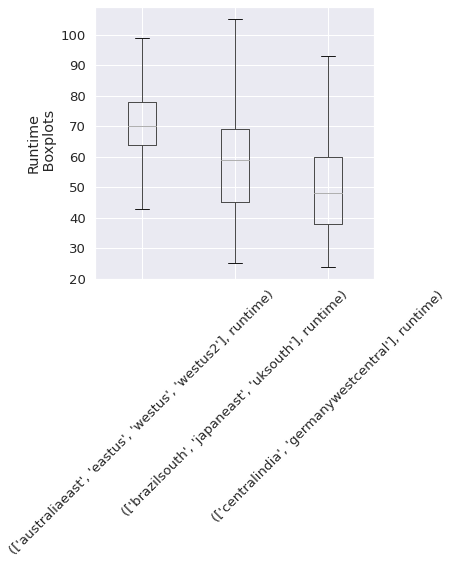

In [8]:
# Get MF finding numners for Azure Groups:
# % TODO: Calculate average runtimes for the different groups:
group_1 = ['australiaeast', 'eastus', 'westus', 'westus2']
group_2 = ['brazilsouth', 'japaneast', 'uksouth']
group_3 = ['centralindia', 'germanywestcentral']

df_grouped_runtime = df[df['region'].isin(group_1 + group_2 + group_3)][['provider', 'region', 'runtime']]
df_grouped_runtime['group'] = 'none'
df_grouped_runtime.loc[df_grouped_runtime['region'].isin(group_1), 'group'] = str(group_1)
df_grouped_runtime.loc[df_grouped_runtime['region'].isin(group_2), 'group'] = str(group_2)
df_grouped_runtime.loc[df_grouped_runtime['region'].isin(group_3), 'group'] = str(group_3)

df_grouped_runtime_result = df_grouped_runtime.groupby('group')

# CV Boxplots
fig, axes = plt.subplots(figsize=(5,5))   
custom_boxplot(axes, df_grouped_runtime_result, "Runtime\n Boxplots", lambda x: x, rot=45)
utils.savefig(fig, ['region_analysis', f'azure_grouped_runtime'], data=df_grouped_runtime_result.describe())

## Runtime Distribution Across All Providers

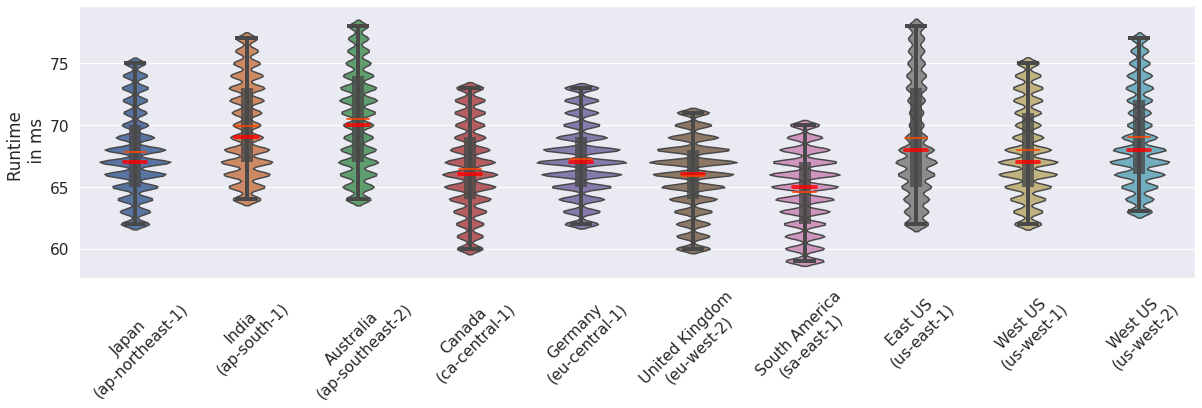

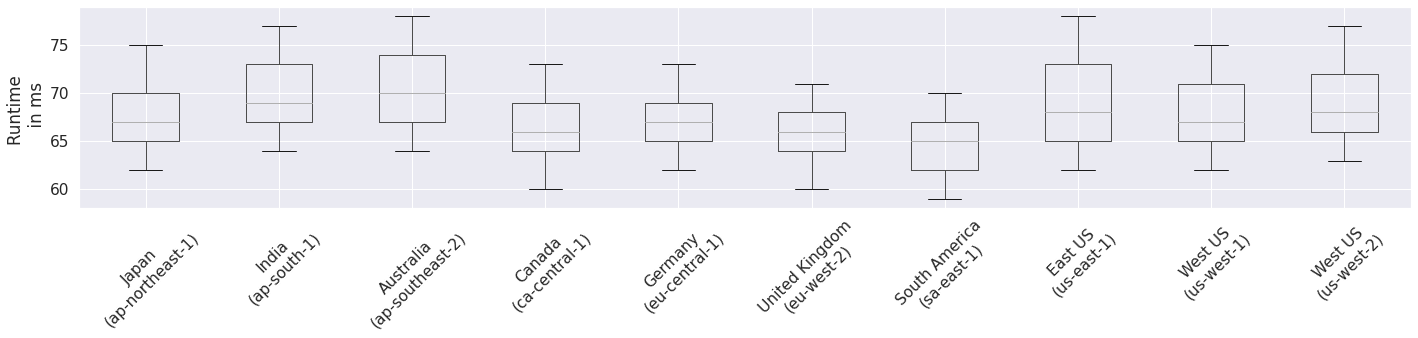

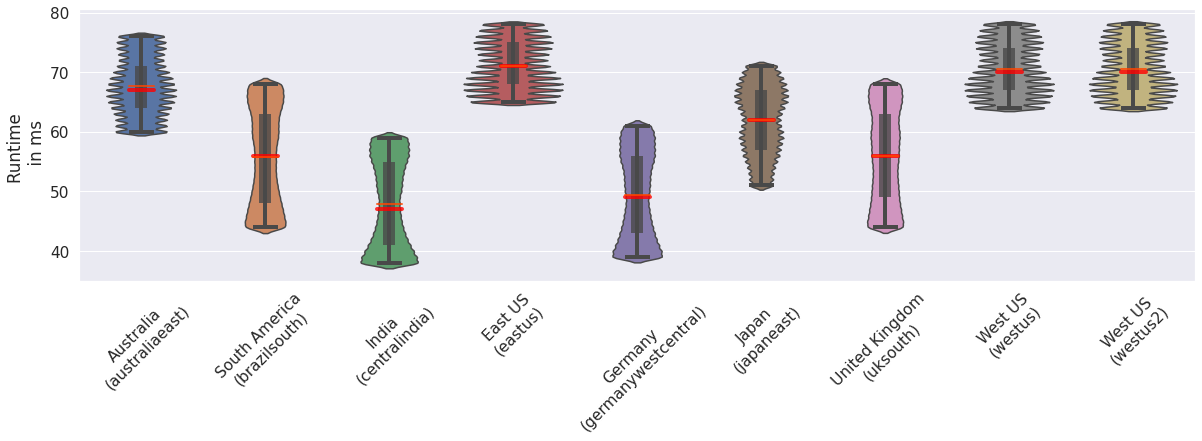

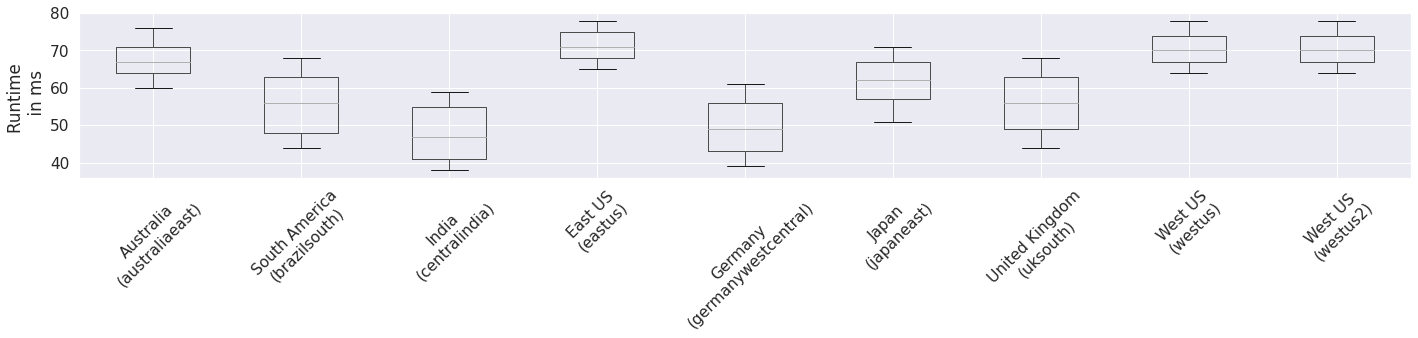

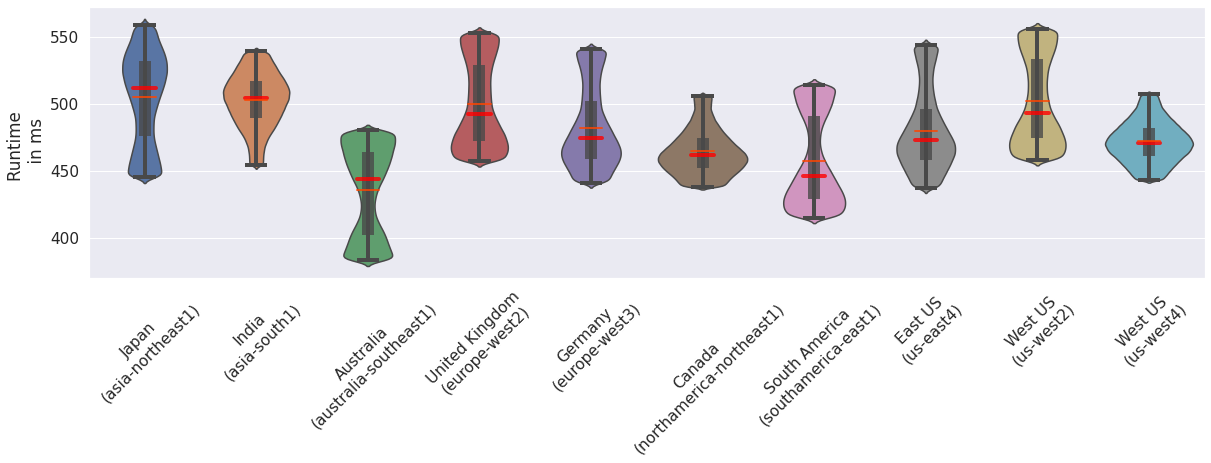

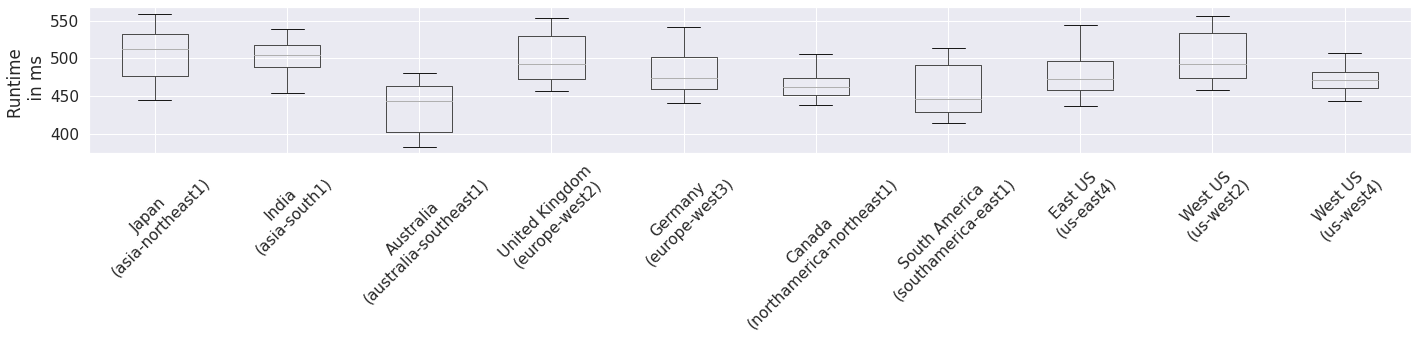

In [9]:
sns.set(font_scale=1.4)

for provider in df['provider'].unique():
    SHAREX = False
    pdf = df[['provider', 'region', 'runtime']][df['provider'] == provider]
    regions = list(pdf['region'].unique())
    no_regions = len(regions)
    fig, axes = plt.subplots(figsize=(20,5)) #, ncols=no_regions, frameon=False, sharex=SHAREX, sharey=True)
    index = 0
    pdf = utils.remove_outliers_group_quantiles(pdf, 'region', 'runtime')
    
    # todo check if ok
    pdf['runtime'] = pdf['runtime'].astype(np.float64)
    pdf['region'] = pdf['region'].cat.remove_unused_categories()
    
    ax = violinplotutil.violinplot(x='region', y='runtime', ax=axes, data=pdf)
    
    axes.set_ylabel('Runtime \n in ms')
    
    utils.savefig(fig, ['region_analysis', f'runtime_violin_provider_{provider}'],
             bxdf=pdf.groupby('region').describe()
                 )
    
    region_name_ax = ax
    labels = []
    for tick in region_name_ax.get_xticklabels():
        region = tick.get_text()
        key = f"({provider}, {region})"
        mapping = provider_region_mapping[key]
        region = mapping['region']
        measure_group = mapping['measure group']
        labels.append(f"{measure_group}\n({region})")
    region_name_ax.set_xticklabels(labels, rotation=45)
    region_name_ax.set_xlabel('')
        
    fig = plt.figure(figsize=(20,5))  #plt.subplots(figsize=(20,5)) #, ncols=no_regions, frameon=False, sharex=SHAREX, sharey=True)
    ax = plt.gca()
    
    bxdf = pdf.groupby(['provider','region'], observed=True)
    custom_boxplot(ax, bxdf, "Runtime \n in ms", lambda x: x, rot=45, sharex=False)
    
    region_name_ax = ax
    labels = []
    for tick in region_name_ax.get_xticklabels():
        region =  tick.get_text().split(',')[1].strip()
        key = f"({provider}, {region})"
        mapping = provider_region_mapping[key]
        region = mapping['region']
        measure_group = mapping['measure group']
        labels.append(f"{measure_group}\n({region})")
    region_name_ax.set_xticklabels(labels, rotation=45)
    region_name_ax.set_xlabel('')
    
    fig.tight_layout()
    
    utils.savefig(fig, ['region_analysis', f'runtime_boxplot_provider_{provider}'],
             bxdf=bxdf.describe()
                 )

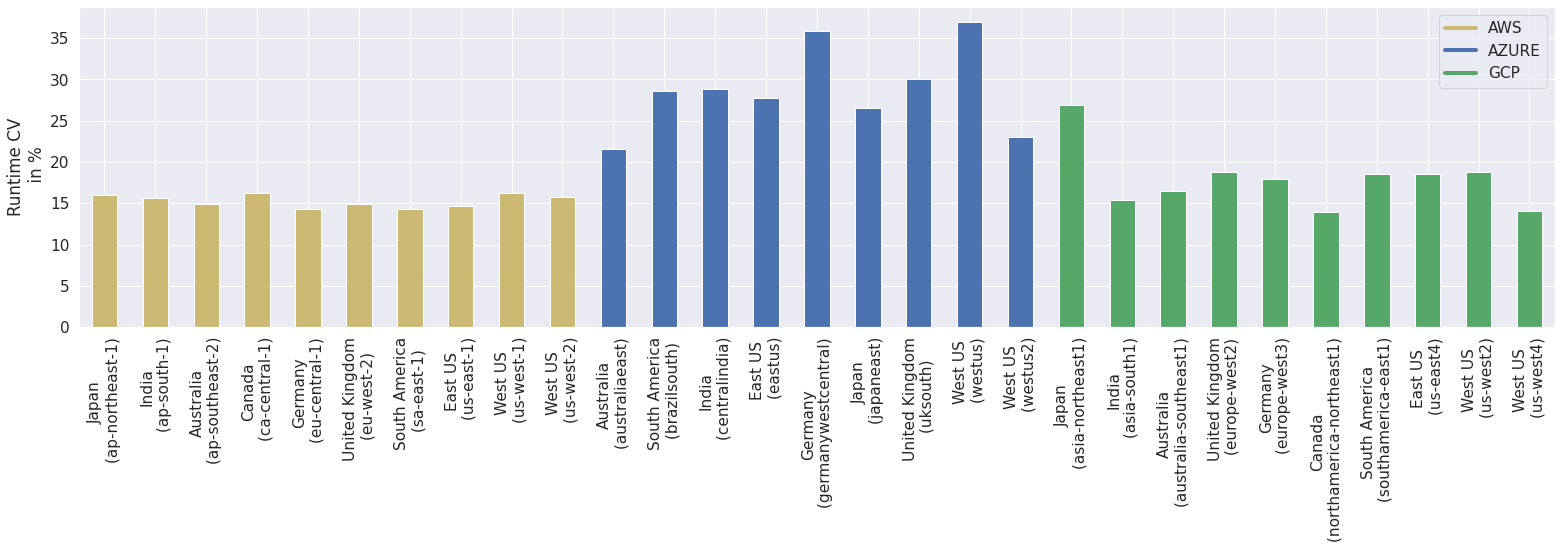

In [10]:
fig, ax = plt.subplots(figsize=(22,8))
cov_df_percent = cov_df * 100
bars = cov_df_percent.plot(ax=ax, kind='bar', color= (['y'] * 10 ) + (['b'] * 9) + (['g'] * 10) )

region_name_ax = ax
labels = []
for tick in region_name_ax.get_xticklabels():
    provider =  tick.get_text().split(',')[0].strip()[1:]
    region =  tick.get_text().split(',')[1].strip()[:-1]
    key = f"({provider}, {region})"
    mapping = provider_region_mapping[key]
    label = f"{provider} {mapping['region']}"
    measure_group = mapping['measure group']
    label = f"{measure_group}\n ({region})"
    labels.append(label)
region_name_ax.set_xticklabels(labels, rotation=90)
region_name_ax.set_xlabel('')

region_name_ax.set_ylabel('Runtime CV\n in %')

from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='y', lw=4),
                Line2D([0], [0], color='b', lw=4),
                Line2D([0], [0], color='g', lw=4)]


ax.legend(custom_lines, ['AWS', 'AZURE', 'GCP'])

fig.tight_layout()

utils.savefig(fig, ['region_analysis', f'cv_all_regions'], data=cov_df)

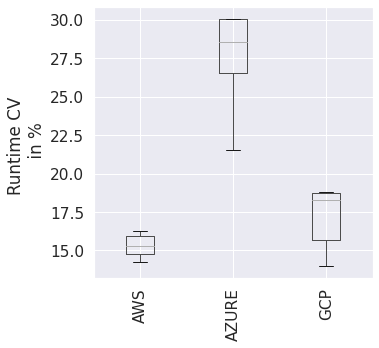

In [11]:
# CV Boxplots
cov_df.groupby('provider')
fig, axes = plt.subplots(figsize=(5,5))

cov_df_percent = cov_df * 100
bxdf = cov_df_percent.reset_index().groupby(['provider'])
custom_boxplot(axes, bxdf, "Runtime CV \n in %", lambda x: x, rot=45)

labels = []
for tick in axes.get_xticklabels():
    provider =  tick.get_text().split(',')[0].strip()[1:]
    labels.append(provider)
axes.set_xticklabels(labels, rotation=90)

utils.savefig(fig, ['region_analysis', f'cv_boxplot'], data=cov_df)

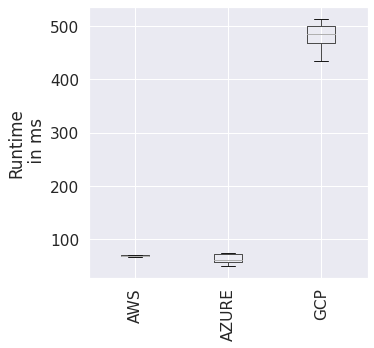

In [12]:
# Runtime Boxplots
mean_region_df = df[['provider', 'region', 'runtime']].groupby(['provider', 'region'], observed=True).mean()
mean_region_df

fig, axes = plt.subplots(figsize=(5,5))
    
bxdf = mean_region_df.groupby('provider')

custom_boxplot(axes, bxdf, "Runtime\n in ms", lambda x: x, rot=45)

labels = []
for tick in axes.get_xticklabels():
    provider =  tick.get_text().split(',')[0].strip()[1:]
    labels.append(provider)
axes.set_xticklabels(labels, rotation=90)

utils.savefig(fig, ['region_analysis', f'runtime_boxplot'], cvbx=bxdf.describe())

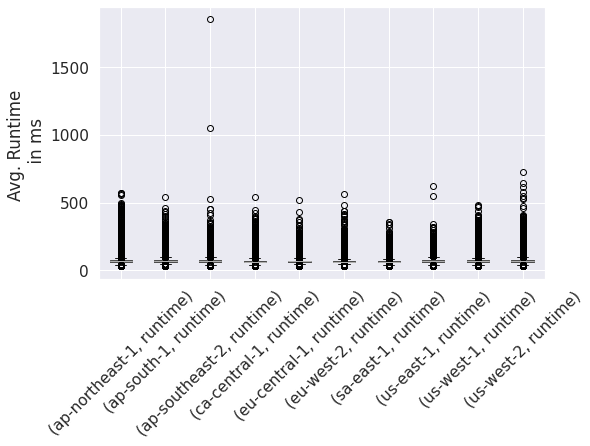

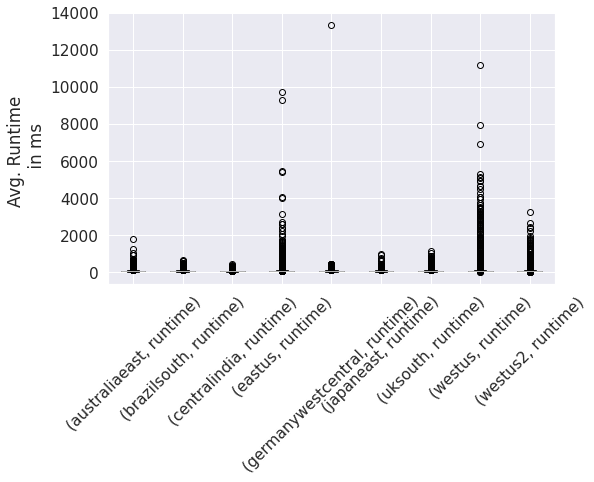

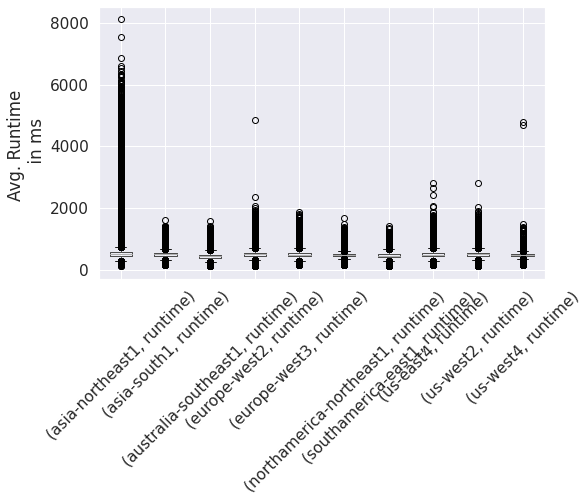

In [13]:
# Mean Runtime with Outliers
for provider in cov_df.index.get_level_values('provider').unique():
    fig, axes = plt.subplots(figsize=(8,5))
    df[['provider', 'region', 'runtime']][df['provider'] == provider].groupby(['region'], observed=True).boxplot(subplots=False, ax=axes, rot=45)
    for tick in axes.get_xticklabels():
        tick.set_rotation(45)
    
    axes.set_ylabel('Avg. Runtime \n in ms')
    plt.show()
    plt.close()

# CPU Types Analysis
Different Types of CPUs for the different regions.

In [14]:
unique_cpu_types_df = df.groupby(['provider', 'region', 'cpuType'], observed=True)['cpuType'].count() #.agg({'cpuType':'count'})
unique_cpu_types_df = pd.DataFrame(unique_cpu_types_df).groupby(['provider', 'region'], group_keys=False).apply(lambda df: (df['cpuType'] / df['cpuType'].sum()) * 100)
unique_cpu_types_percentage_df = pd.DataFrame(unique_cpu_types_df)
unique_cpu_types_percentage_df = unique_cpu_types_percentage_df.rename(columns={'cpuType': 'Percentage'})
unique_cpu_types_percentage_df = unique_cpu_types_percentage_df.reset_index('cpuType')
unique_cpu_types_pivoted_df = unique_cpu_types_percentage_df.pivot(columns=['cpuType'])

In [15]:
cpu_map = {
    "Intel(R) Xeon(R) Processor @ 2.50GHz - Model 63": "Xeon @2.50GHz - Model 63",
    "Intel(R) Xeon(R) Platinum 8171M CPU @ 2.60GHz - Model 85": "Xeon Platinum 8171M @2.60GHz - Model 85",
    "Intel(R) Xeon(R) CPU E5-2673 v4 @ 2.30GHz - Model 79": "Xeon E5-2673 v4 @2.30GHz - Model 79",
    "Intel(R) Xeon(R) Platinum 8272CL CPU @ 2.60GHz - Model 85": "Xeon Platinum 8272CL @2.60GHz - Model 85",
    "Intel(R) Xeon(R) CPU E5-2673 v3 @ 2.40GHz - Model 63": "Xeon CPU E5-2673 v3 @2.40GHz - Model 63",
    "Intel(R) Xeon(R) Processor @ 3.00GHz - Model 63": "Xeon @3.00GHz - Model 63",
    "unknown - Model 85": "Model 85",
    "unknown - Model 79": "Model 79",
    "unknown - Model 63": "Model 63"
}

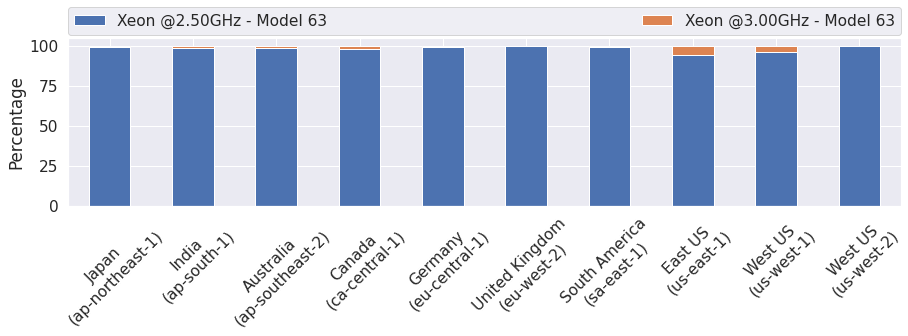

cpu_types_percentrage 
                 Xeon @2.50GHz - Model 63  Xeon @3.00GHz - Model 63
region                                                            
ap-northeast-1                 99.588313                  0.411687
ap-south-1                     98.645013                  1.354987
ap-southeast-2                 98.945640                  1.054360
ca-central-1                   97.880335                  2.119665
eu-central-1                   99.694243                  0.305757
eu-west-2                      99.931559                  0.068441
sa-east-1                      99.375028                  0.624972
us-east-1                      94.308619                  5.691381
us-west-1                      96.549660                  3.450340
us-west-2                      99.954666                  0.045334


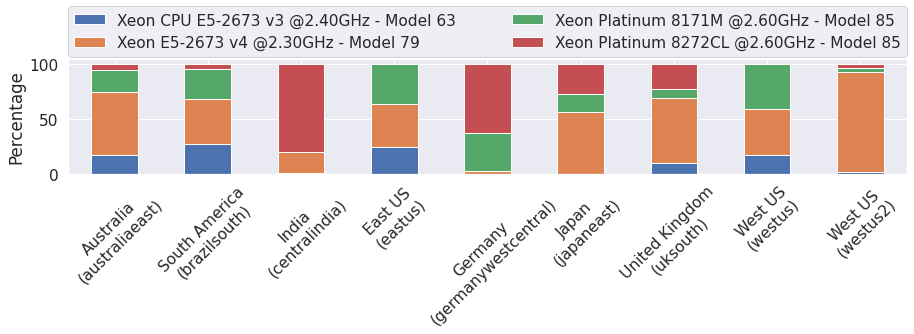

cpu_types_percentrage 
                     Xeon CPU E5-2673 v3 @2.40GHz - Model 63  \
region                                                        
australiaeast                                     16.797081   
brazilsouth                                       26.982614   
centralindia                                       0.309975   
eastus                                            24.544859   
germanywestcentral                                      NaN   
japaneast                                          0.076161   
uksouth                                           10.108581   
westus                                            16.786612   
westus2                                            1.140948   

                    Xeon E5-2673 v4 @2.30GHz - Model 79  \
region                                                    
australiaeast                                 57.619793   
brazilsouth                                   41.387051   
centralindia                                  

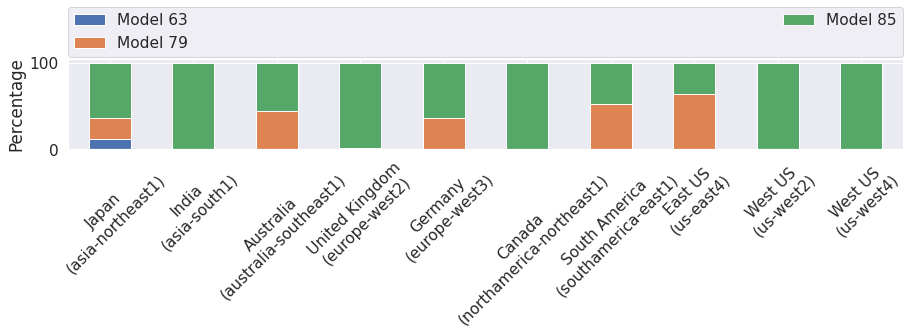

cpu_types_percentrage 
                          Model 63   Model 79    Model 85
region                                                  
asia-northeast1          12.31664  24.192825   63.490535
asia-south1                   NaN        NaN  100.000000
australia-southeast1          NaN  44.288705   55.711295
europe-west2                  NaN   2.091200   97.908800
europe-west3                  NaN  36.124145   63.875855
northamerica-northeast1       NaN        NaN  100.000000
southamerica-east1            NaN  52.392529   47.607471
us-east4                      NaN  63.604870   36.395130
us-west2                      NaN        NaN  100.000000
us-west4                      NaN        NaN  100.000000


In [16]:
for provider in df['provider'].unique():
    fig, axes = plt.subplots(figsize=(13,5))
    subdf = unique_cpu_types_pivoted_df

    providerdf = subdf.loc[provider]

    cols = providerdf.columns.droplevel(0)
    new_cols = [cpu_map[x] for x in cols]
    providerdf.columns = new_cols
    providerdf = providerdf.dropna(axis=1, how='all')
    
    providerdf.plot.bar(stacked=True, ax=axes, rot=45)

    axes.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=2)
    axes.set_xlabel('')
    axes.set_ylabel('Percentage')
    
    # Set Region Names
    labels = []
    for tick in axes.get_xticklabels():
        region = tick.get_text()
        key = f"({provider}, {region})"
        mapping = provider_region_mapping[key]
        region = mapping['region']
        measure_group = mapping['measure group']
        labels.append(f"{measure_group}\n({region})")
    axes.set_xticklabels(labels)
    
    fig.tight_layout()
    utils.plot( ['region_analysis', f'cpu_types_{provider}'], cpu_types_percentrage=providerdf)

In [17]:
cputype_per_invocation_df = pd.DataFrame(df.groupby(['provider', 'region', 'driver_invocation'], observed=True)['cpuType'].nunique().rename('Count'))

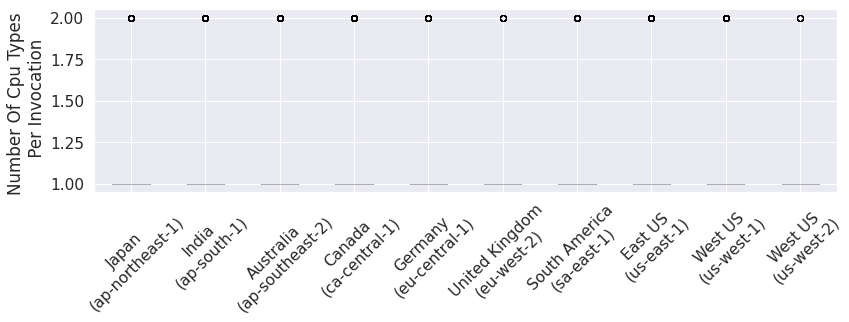

cputype_per_invocation_df 
                  Count                                             
                 count      mean       std  min  25%  50%  75%  max
region                                                             
ap-northeast-1  2895.0  1.014508  0.119592  1.0  1.0  1.0  1.0  2.0
ap-south-1      2894.0  1.045957  0.209428  1.0  1.0  1.0  1.0  2.0
ap-southeast-2  2896.0  1.034530  0.182619  1.0  1.0  1.0  1.0  2.0
ca-central-1    2897.0  1.072144  0.258770  1.0  1.0  1.0  1.0  2.0
eu-central-1    2895.0  1.011744  0.107752  1.0  1.0  1.0  1.0  2.0
eu-west-2       2893.0  1.002765  0.052522  1.0  1.0  1.0  1.0  2.0
sa-east-1       2893.0  1.019703  0.139001  1.0  1.0  1.0  1.0  2.0
us-east-1       2887.0  1.200208  0.400225  1.0  1.0  1.0  1.0  2.0
us-west-1       2893.0  1.092637  0.289974  1.0  1.0  1.0  1.0  2.0
us-west-2       2886.0  1.001733  0.041594  1.0  1.0  1.0  1.0  2.0


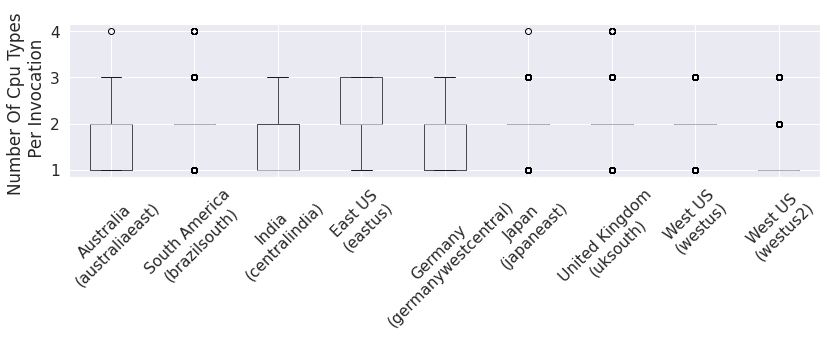

cputype_per_invocation_df 
                      Count                                             
                     count      mean       std  min  25%  50%  75%  max
region                                                                 
australiaeast       2884.0  1.901179  0.664974  1.0  1.0  2.0  2.0  4.0
brazilsouth         2880.0  2.062500  0.642576  1.0  2.0  2.0  2.0  4.0
centralindia        2895.0  1.450086  0.502426  1.0  1.0  1.0  2.0  3.0
eastus              2871.0  2.230930  0.584913  1.0  2.0  2.0  3.0  3.0
germanywestcentral  2897.0  1.651363  0.522252  1.0  1.0  2.0  2.0  3.0
japaneast           2894.0  1.991707  0.618809  1.0  2.0  2.0  2.0  4.0
uksouth             2893.0  2.031801  0.667118  1.0  2.0  2.0  2.0  4.0
westus              2843.0  2.074217  0.609374  1.0  2.0  2.0  2.0  3.0
westus2             2896.0  1.254144  0.497646  1.0  1.0  1.0  1.0  3.0


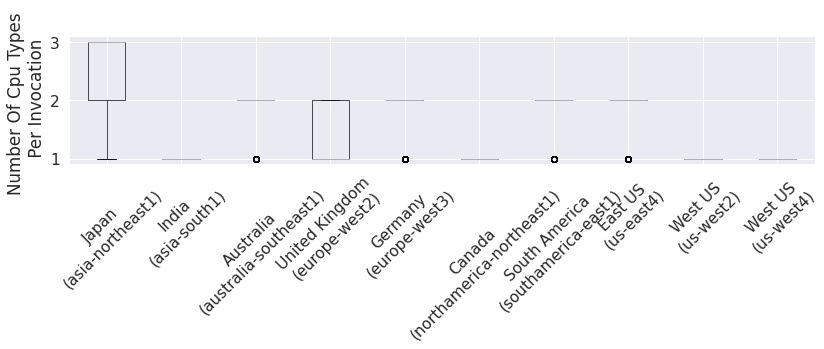

cputype_per_invocation_df 
                           Count                                             
                          count      mean       std  min  25%  50%  75%  max
region                                                                      
asia-northeast1          2900.0  2.682759  0.496326  1.0  2.0  3.0  3.0  3.0
asia-south1              2901.0  1.000000  0.000000  1.0  1.0  1.0  1.0  1.0
australia-southeast1     2901.0  1.971044  0.167710  1.0  2.0  2.0  2.0  2.0
europe-west2             2901.0  1.255084  0.435984  1.0  1.0  1.0  2.0  2.0
europe-west3             2901.0  1.925198  0.263117  1.0  2.0  2.0  2.0  2.0
northamerica-northeast1  2901.0  1.000000  0.000000  1.0  1.0  1.0  1.0  1.0
southamerica-east1       2900.0  1.986207  0.116651  1.0  2.0  2.0  2.0  2.0
us-east4                 2901.0  1.895898  0.305446  1.0  2.0  2.0  2.0  2.0
us-west2                 2900.0  1.000000  0.000000  1.0  1.0  1.0  1.0  1.0
us-west4                 2900.0  1.000000  0.000

In [18]:
for provider in df['provider'].unique():
    fig, axes = plt.subplots(figsize=(12,5))
    subdf = cputype_per_invocation_df
    provdf = subdf.loc[provider]
    provdf.boxplot(by='region', rot=45, ax=axes)
    
    # Set Region Names
    labels = []
    for tick in axes.get_xticklabels():
        region = tick.get_text()
        key = f"({provider}, {region})"
        mapping = provider_region_mapping[key]
        region = mapping['region']
        measure_group = mapping['measure group']
        labels.append(f"{measure_group}\n({region})")
    axes.set_xticklabels(labels)
    
    # Other Formatting
    axes.set_title('')
    fig.suptitle('')
    axes.set_xlabel('')
    axes.set_ylabel('Number Of Cpu Types \n Per Invocation')
    
    fig.tight_layout()
    utils.plot( ['region_analysis', f'invocation_cpu_types_{provider}'], cputype_per_invocation_df=provdf.groupby('region').describe())